In [703]:
import sys
import sqlite3
import math
import warnings
import struct
import itertools
import numpy as np
import scipy.fftpack
import scipy.signal
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.dates
import scipy.optimize
%matplotlib notebook

In [704]:
db = sqlite3.connect('test_run.sqlite3')

In [705]:
#last_run, = db.execute('SELECT MAX(run_id) FROM packets').fetchone()
# Override
#last_run = 40
last_run=33

Loading run #28 with 4918 packets total, 178 distinct over 161.5061011314392s


<IPython.core.display.Javascript object>


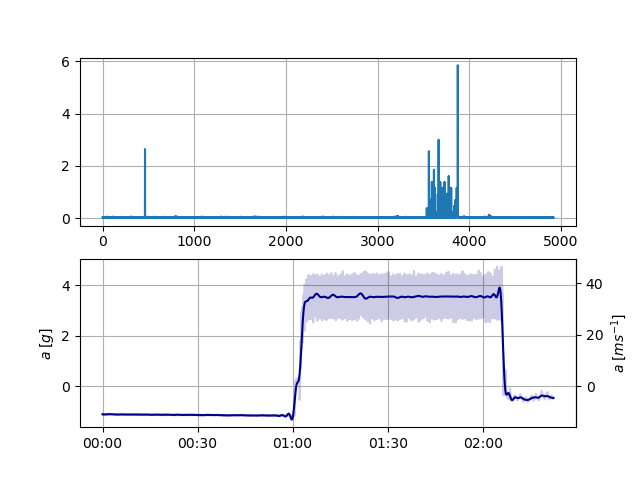

Packet length: 40
Very approximate lower bound on baudrate: 129032.25806451612 bd
Sequence number range: 611 ... 813


In [836]:
def decode_packet(packet):
    seq, *data, _crc = struct.unpack('<I16hI', packet)
    return (seq, tuple(data))

def plot_measurements(ax, t, y):
    ax.grid()
    ax.plot(t, y / mems_lsb_per_g, color='darkblue', alpha=0.2)
    #ax.plot(ts, scipy.signal.savgol_filter(reassembled_values / mems_lsb_per_g, 21, 2) )
    sos = scipy.signal.butter(8, 0.5, 'lp', fs=10, output='sos')
    filtered = scipy.signal.sosfiltfilt(sos, y / mems_lsb_per_g)
    ax.plot(t, filtered, color='darkblue')
    
    ax.set_ylabel(r'$a\; [g]$')
    secax_y = ax.secondary_yaxis(
        'right', functions=(g_to_ms, ms_to_g))
    secax_y.set_ylabel(r'$a\; [ms^{-1}]$')

    formatter = ticker.FuncFormatter(lambda tick, _pos: f'{int(tick):02d}:{tick*60%60:02.0f}')
    ax.xaxis.set_major_formatter(formatter)

def load_run(run_id, plot=True):
    num_packets, = db.execute('SELECT COUNT(*) FROM packets WHERE run_id=?', (run_id,)).fetchone()
    num_packets_distinct, = db.execute('SELECT COUNT(*) FROM (SELECT DISTINCT data FROM packets WHERE run_id=?)', (run_id,)).fetchone()
    timespan_start, timespan_end = db.execute('SELECT MIN(timestamp_us)/1e6, MAX(timestamp_us)/1e6 FROM packets WHERE run_id=?', (run_id,)).fetchone()
    timespan = timespan_end - timespan_start
    print(f'Loading run #{run_id} with {num_packets} packets total, {num_packets_distinct} distinct over {timespan}s')
    
    packet_timestamps = db.execute('SELECT timestamp_us/1e6 FROM packets WHERE run_id=? ORDER BY timestamp_us', (run_id,)).fetchall()
    packet_timestamps = [ ts - timespan_start for ts, in packet_timestamps ]
    packet_delays = [ b-a for a, b in zip(packet_timestamps[:-1], packet_timestamps[1:]) ]
    
    if plot:
        fig, (ax1, ax2) = plt.subplots(2)
        ax1.grid()
        ax1.plot(packet_delays)
    
    packet_lengths = db.execute('SELECT LENGTH(data) FROM packets WHERE run_id=? GROUP BY LENGTH(data)', (run_id,)).fetchall()
    assert len(packet_lengths) == 1
    packet_len, = packet_lengths[0]
    print('Packet length:', packet_len)
    
    #approx_baudrate = 1.0 / (np.mean([ x for x in deltas if x < interval*0.02]) / (packet_len*10))
    approx_baudrate = 1.0 / (0.0031 / (packet_len*10))
    print(f'Very approximate lower bound on baudrate: {approx_baudrate} bd')
    
    packets = sorted([ decode_packet(data) for data, in db.execute('SELECT data FROM packets WHERE run_id=?', (run_id,)) ])
    
    # group packets by sequence number
    by_seq = { k: list(g) for k, g in itertools.groupby(packets, key=lambda x: x[0]) }
    for seq, le_packets in by_seq.items():
        # make sure we only ever have one version of a packet with a particular sequence number (no CRC collisions)
        if len(set(le_packets)) > 1:
            # In test_run.sqlite3 run 2 this happens to coincide with the time I intentionally bumped the rotor... ?
            warnings.warn(f'BUG: Duplicate sequence number {seq} for {len(set(le_packets))} payloads!')
            print('BUG: Duplicate sequence number')
            print('Sequence number:', seq)
            for seq, data in set(le_packets):
                print('   ', data)
                
    seqs = list(by_seq)
    print(f'Sequence number range: {min(seqs)} ... {max(seqs)}')
    
    # FIXME this is only approximate, doesn't consider sequence numbers properly!!!
    # Negate values: Our sensor is mounted such that -X points outwards,
    # so by negating we get larger centrifugal force -> higher value
    y = np.array([ -val for (_seq, values), *_rest in by_seq.values() for val in values[:8] ])
    t = np.arange(0, len(y)) / sampling_rate / 60
    if plot:
        plot_measurements(ax2, t, y)
    return t, y, packet_delays, packet_timestamps
    
load_run(28);

Loading run #40 with 4762 packets total, 682 distinct over 572.8108429908752s
Packet length: 40
Very approximate lower bound on baudrate: 129032.25806451612 bd
Sequence number range: 739 ... 1457


<IPython.core.display.Javascript object>


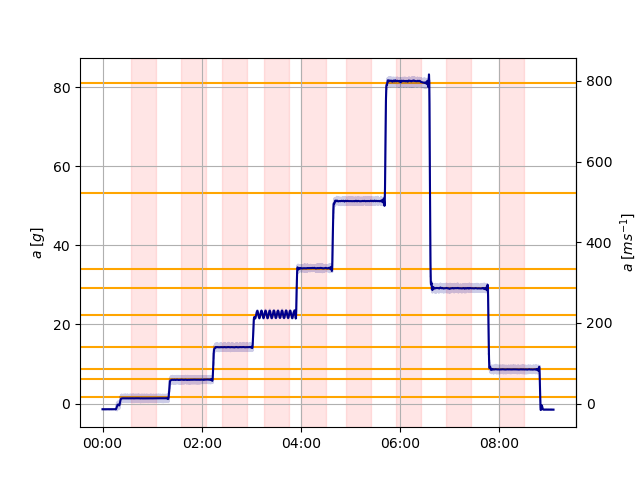

Found sensor offset: 0.57 g / 5.55 m/s^2

Centrifugal acceleration at 3.12 Hz:
         Theory: 2.16 g / 21.14 m/s^2
    Measurement: 1.90 g / 18.586194313627637 m/s^2
     Rel. Error: 13.72 %
     Abs. Error: 0.26 g / 2.55 m/s^2

Centrifugal acceleration at 5.55 Hz:
         Theory: 6.82 g / 66.88 m/s^2
    Measurement: 6.60 g / 64.67817413725541 m/s^2
     Rel. Error: 3.41 %
     Abs. Error: 0.22 g / 2.20 m/s^2

Centrifugal acceleration at 8.20 Hz:
         Theory: 14.89 g / 146.00 m/s^2
    Measurement: 14.82 g / 145.35641444809548 m/s^2
     Rel. Error: 0.44 %
     Abs. Error: 0.07 g / 0.64 m/s^2

Centrifugal acceleration at 10.20 Hz:
         Theory: 23.04 g / 225.90 m/s^2
    Measurement: 23.11 g / 226.6766272456559 m/s^2
     Rel. Error: -0.34 %
     Abs. Error: -0.08 g / -0.77 m/s^2

Centrifugal acceleration at 12.50 Hz:
         Theory: 34.60 g / 339.27 m/s^2
    Measurement: 34.80 g / 341.26606334638393 m/s^2
     Rel. Error: -0.59 %
     Abs. Error: -0.20 g / -2.00 m/s^2

Ce

In [1019]:
t, y, _1, _2 = load_run(40, plot=False)

sampling_rate = 10 # sps, set in firmware
mems_lsb_per_g = 68 # LSBs per 1g for our accelerometer

ivl_start, ivl_end = 0.5, 1
ivl_start, ivl_end = int(ivl_start*60*sampling_rate), int(ivl_end*60*sampling_rate)

fig, ax = plt.subplots()
#ax.axvspan(ivl_start/60/sampling_rate, ivl_end/60/sampling_rate, color='orange', alpha=0.5)
    
plot_measurements(ax, t, y)

g = 9.8066
g_to_ms = lambda x: x * g
ms_to_g = lambda x: x / g

r_mems = 55e-3 # radius of our sensor from the axis of rotation in m
le_data = [(0, 50, 3.12), (1,50,5.55), (2,40, 8.2), (3, 30, 10.2), (4,15, 12.5), (5,10, 15.6),
           (6,10, 19.2), (7,11, 11.6), (8,15, 6.49)]
avg_include = [True, True, True, True, True, False, True, True, True]
acc_theory = []
acc_meas = []

for ts_m, ts_s, f_actual in le_data:
    omegan = 2*np.pi*f_actual # angular velocity
    acc = omegan**2 * r_mems # m/s^2
    acc_theory.append(acc / g)
    ax.axvspan(ts_abs-ivl_w/2, ts_abs+ivl_w/2, zorder=1, color='red', alpha=0.1)
    
    ts_abs = ts_m + ts_s/60
    ivl_w = 0.5
    idx = (ts_abs - ivl_w/2 < t) & (t < ts_abs + ivl_w/2)
    ivl_avg = (y / mems_lsb_per_g)[idx].mean()
    acc_meas.append(ivl_avg)

# Calculate offset correction. The offset is due to manufacturing imperfections inherent to the device.
# Note that while in the "0Hz" still part of the line at the beginning and end of the trace we see a
# fraction of earth's gravity due to the sensor's position inside the device and the way the device lies
# on the workbench, this offset cancels out once the device is rotating.
#
# Our sensor is specified to have up to +/- 1.0 g offset. This is due to its large +/- 120 g range
# and we're well within that.
#
# The sensor's nonlinearity error is specified as +/- 2 %FS and we're well within that as well.

def fun(x, *args):
    return np.sqrt(np.mean([ (meas - x[0] - theory)**2
                            for theory, meas, inc in zip(acc_theory, acc_meas, avg_include)
                            if inc ]))
res = scipy.optimize.minimize(fun, 1)
sensor_offx = np.abs(res.x[0])

print(f'Found sensor offset: {sensor_offx:.2f} g / {sensor_offx*g:.2f} m/s^2')
print()

for theory, meas, interval, (_1, _2, f_actual) in zip(acc_theory, acc_meas, interval_speeds, le_data):
    ax.axhline(theory - sensor_offx, color='orange', alpha=1, zorder=1)
    meas += sensor_offx
        
    print(f'Centrifugal acceleration at {f_actual:.2f} Hz:')
    print(f'         Theory: {theory:.2f} g / {theory*g:.2f} m/s^2')
    print(f'    Measurement: {meas:.2f} g / {meas*g} m/s^2')
    print(f'     Rel. Error: {(theory/meas - 1.0) * 100:.2f} %')
    print(f'     Abs. Error: {theory-meas:.2f} g / {(theory-meas)*g:.2f} m/s^2')
    print()

<IPython.core.display.Javascript object>


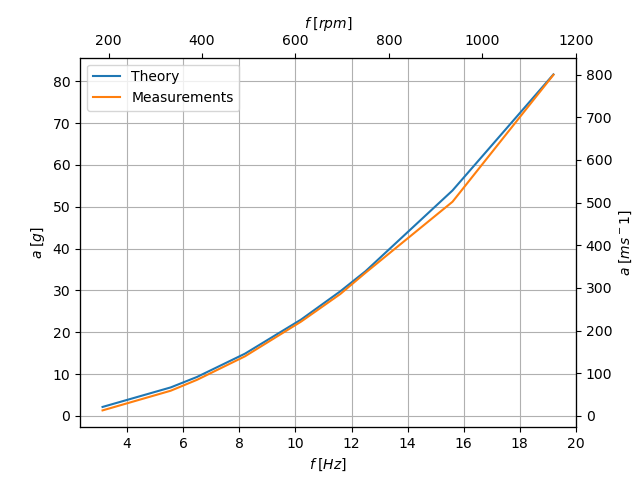

In [1022]:
fig, ax = plt.subplots()

freqs = np.array([ f_actual for (_1, _2, f_actual) in le_data ])

acc_theory_sorted = [ acc for _f, acc in sorted(zip(freqs, acc_theory)) ]
acc_meas_sorted = [ acc for _f, acc in sorted(zip(freqs, acc_meas)) ]
freqs = sorted(freqs)

ax.plot(freqs, acc_theory_sorted, label='Theory')
ax.plot(freqs, acc_meas_sorted, label='Measurements')
    
ax.grid()
ax.set_xlabel('$f\;[Hz]$')
ax2 = ax.twiny()
x1, x2 = ax.get_xlim()
ax2.set_xlim((x1*60, x2*60))
ax2.set_xlabel('$f\;[rpm]$')
ax.set_ylabel('$a\;[g]$')
ax3 = ax.twinx()
y1, y2 = ax.get_ylim()
ax3.set_ylim(y1*g, y2*g)
ax3.set_ylabel('$a\;[ms^-1]$')

ax.legend()

Loading run #33 with 3178 packets total, 125 distinct over 99.94346904754639s
Packet length: 40
Very approximate lower bound on baudrate: 129032.25806451612 bd
Sequence number range: 35 ... 161


<IPython.core.display.Javascript object>


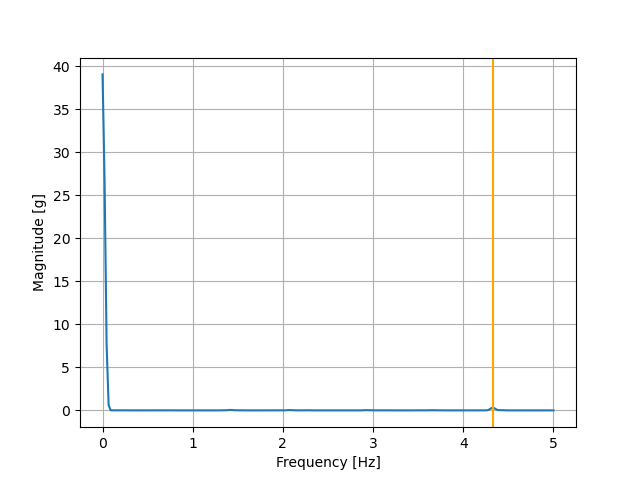

Largest peak at 4.33 Hz / 260 rpm
Mixing product 1 at 5.67 Hz / 340 rpm
Mixing product 2 at 14.33 Hz / 860 rpm
Mixing product 3 at 15.67 Hz / 940 rpm
Mixing product 4 at 24.33 Hz / 1460 rpm
Mixing product 5 at 25.67 Hz / 1540 rpm
Mixing product 6 at 34.33 Hz / 2060 rpm


4.3273542600896855

In [957]:
def estimate_freq_fft(t, y, interval):
    s_min, s_max = interval
    fft_idx = (t*60 > s_min) & (t*60 < s_max)

    N = fft_idx.sum()
    T = 1/sampling_rate
    x = np.linspace(0.0, N*T, N)
    y = y[fft_idx] / mems_lsb_per_g # cut out beginning and that time we tapped the thing
    y *= scipy.signal.windows.blackmanharris(len(y))
    yf = scipy.fftpack.fft(y)
    xf = np.linspace(0.0, 1/(2*T), N//2)
    mag = 2/N * np.abs(yf[:N//2])

    fig, ax = plt.subplots()
    ax.grid()
    ax.plot(xf, mag)
    ax.set_ylabel('Magnitude [g]')
    ax.set_xlabel('Frequency [Hz]')

    peaks, _ = scipy.signal.find_peaks(mag, height=.1, distance=1/T)
    assert peaks.any()

    peak_data = sorted([ (-mag[idx], xf[idx]) for idx in peaks ])
    largest_peak_f = peak_data[0][1]
    print(f'Largest peak at {largest_peak_f:.2f} Hz / {largest_peak_f * 60:.0f} rpm')
    for i in range(1,4):
        mix1 = i*sampling_rate - largest_peak_f
        mix2 = i*sampling_rate + largest_peak_f
        print(f'Mixing product {2*i-1} at {mix1:.2f} Hz / {mix1 * 60:.0f} rpm')
        print(f'Mixing product {2*i} at {mix2:.2f} Hz / {mix2 * 60:.0f} rpm')

    ax.axvline(largest_peak_f, color='orange')
    return largest_peak_f
    
t, y, packet_delays, packet_times = load_run(33, plot=False)
estimate_freq_fft(t, y, (30, 75))

Loading run #33 with 3178 packets total, 125 distinct over 99.94346904754639s


<IPython.core.display.Javascript object>


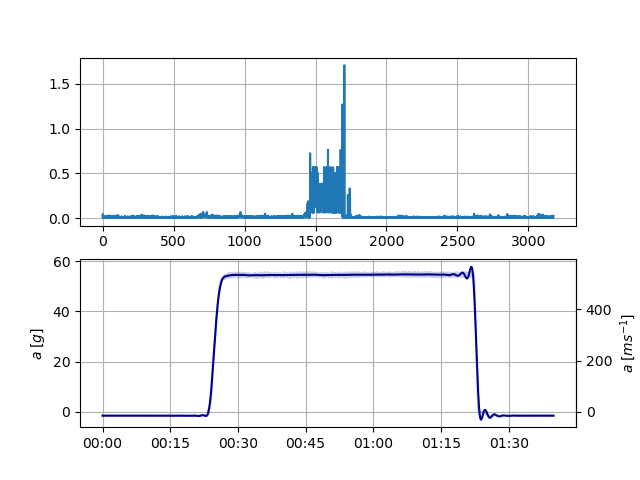

Packet length: 40
Very approximate lower bound on baudrate: 129032.25806451612 bd
Sequence number range: 35 ... 161


In [958]:
load_run(33, plot=True);

<IPython.core.display.Javascript object>


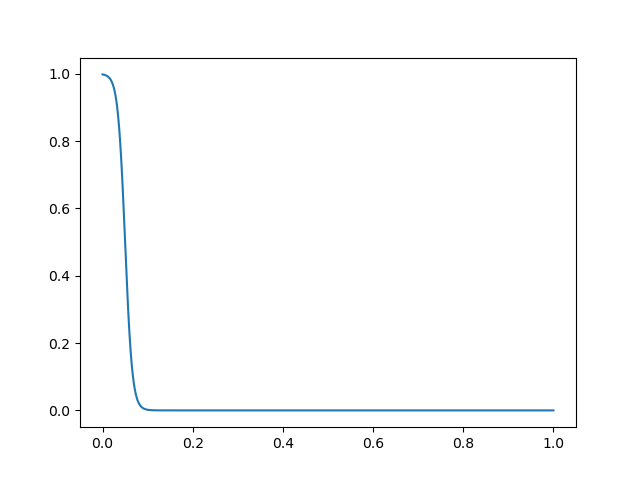

In [959]:
fig, ax = plt.subplots()
x = np.linspace(0, 1, 100000)
y = 1 - (1 + np.tanh((x - 0.05)/0.05 * np.pi))/2
ax.plot(x, y)

<IPython.core.display.Javascript object>


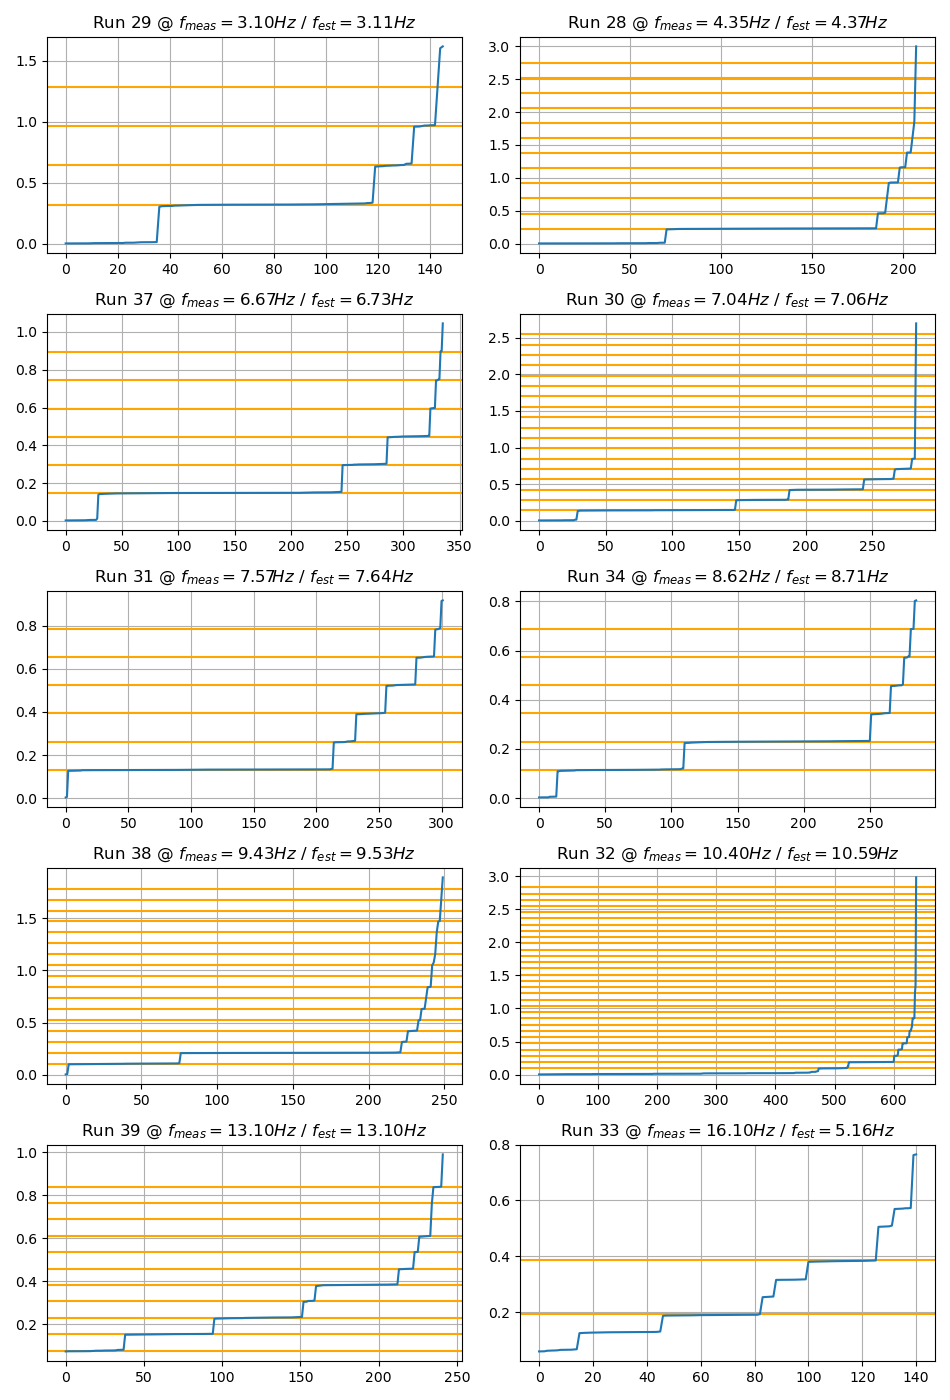


 ===== Run 29: =====
Loading run #29 with 2387 packets total, 206 distinct over 194.01968002319336s
Packet length: 40
Very approximate lower bound on baudrate: 129032.25806451612 bd
Sequence number range: 827 ... 1071
interval: 0.10719954325502887
scores: [0.0005558591029225243, 0.007937380545979303, -0.034688942841427636, 0.009128952125600649, 0.013406031099251599, 0.013555935298953624, 0.017543481008845643, 0.017016779430178704, 0.01657709203008989]
argmin: 3
min score -0.034688942841427636 0.006114450132147767
Average speed of rotation: 3.11 Hz / 187 rpm

    f_meas = 3.10 Hz; f_est = 3.11 Hz
    Δabs = 0.01 Hz; Δrel = +0.3 %

 ===== Run 28: =====
Loading run #28 with 4918 packets total, 178 distinct over 161.5061011314392s
Packet length: 40
Very approximate lower bound on baudrate: 129032.25806451612 bd
Sequence number range: 611 ... 813
interval: 0.11439170940941061
scores: [-0.020534204449181033, -0.03948834332572777, 0.008701765576176747, 0.013951642455491747, 0.014883935285322

In [1000]:
def calc_rspeed_deltas(target_deltas):
    target_deltas = np.array(target_deltas)
    target_deltas = target_deltas[target_deltas > 1/50]
    target_deltas = target_deltas[0:int(len(target_deltas)*0.9)]
    def fun(x):
        rms = np.sqrt(np.mean([ ((val + 0.5*x[0]) % x[0] - 0.5*x[0])**2 for val in target_deltas ]))
        #matches = (target_deltas > 0.5*x[0]).mean()
        matches1 = ((target_deltas > (0.9*x[0])) & (target_deltas < (1.1*x[0]))).mean()
        matches2 = ((target_deltas > (1.9*x[0])) & (target_deltas < (2.1*x[0]))).mean()
        #matchesh= ((target_deltas > (0.45*x[0])) & (target_deltas < (0.55*x[0]))).mean()
        #matches3 = ((target_deltas > (2.9*x[0])) & (target_deltas < (3.1*x[0]))).mean()
        #penalty = 1 - (1 + np.tanh((matches1 - 0.05)/0.05 * np.pi))/2
        return rms - 0.5*matches1 - 0.25*matches2 #+ 0.125*matches3 #+ 0.1*penalty

    #def accept(x_old, x_new, **kwargs):
    #    return 1/30 < x_new[0] and x_new[0] < 1
    res = scipy.optimize.minimize(fun, 0.1)
    #res = scipy.optimize.basinhopping(fun, max(1/largest_peak_f, 0.5), accept_test=accept, stepsize=0.2)
    
    interval = res.x[0]
    scores = [ fun([i*interval]) * (1/(i+10)) for i in range(1, 10) ]
    print('interval:', interval)
    print('scores:', scores)
    argmin = np.argmin(scores)+1
    print('argmin:', argmin)
    print('min score', min(scores), fun([interval*0.5]))
    interval = np.abs(interval) * argmin
    print(f'Average speed of rotation: {1/interval:.2f} Hz / {60 / interval:.0f} rpm')
    return interval

def estimate_freq_delay(delays, times, interval, ax=None):
    s_min, s_max = interval
    tsa = np.array(times)
    idx = (tsa > s_min) & (tsa < s_max)

    target_deltas = sorted(np.array(delays)[idx[:-1]])
    interval = calc_rspeed_deltas(target_deltas)
    
    if ax is not None:
        ax.grid()
        for i in range(1, int(max(target_deltas)//interval)):
            ax.axhline(i*interval, color='orange')
        ax.plot(target_deltas)
    return 1/interval
    
run_spans = {
    28: (4.35, 70, 120),
    29: (3.10, 70, 120),
    30: (7.04, 40, 120),
    31: (7.57, 30, 100),
    32: (10.4, 40, 90),
    33: (16.1, 40, 75),
    34: (8.62, 20, 80),
    37: (6.67, 20, 90),
    38: (9.43, 20, 80),
    39: (13.1, 20, 85),
            }

deltas = []
fig, axs = plt.subplots(5, 2, figsize=(9.5, 14))
for (run_id, (freq_meas, t_start, t_end)), ax in zip(sorted(run_spans.items(), key=lambda x: x[1][0]), axs.flatten()):
    
    print()
    print(f' ===== Run {run_id}: =====')
    t, y, packet_delay, packet_times = load_run(run_id, plot=False)
    freq_est = estimate_freq_delay(packet_delay, packet_times, (t_start, t_end), ax=ax)
    ax.set_title(f'Run {run_id} @ $f_{{meas}} = {freq_meas:02.2f} Hz$ / $f_{{est}} = {freq_est:02.2f} Hz$')
    print()
    print(f'    f_meas = {freq_meas:02.2f} Hz; f_est = {freq_est:02.2f} Hz')
    delta_abs = freq_est - freq_meas
    delta_rel = freq_est/freq_meas-1
    deltas.append((delta_abs, delta_rel))
    print(f'    Δabs = {delta_abs:02.2f} Hz; Δrel = {delta_rel*100:+.1f} %')
fig.tight_layout()

<IPython.core.display.Javascript object>


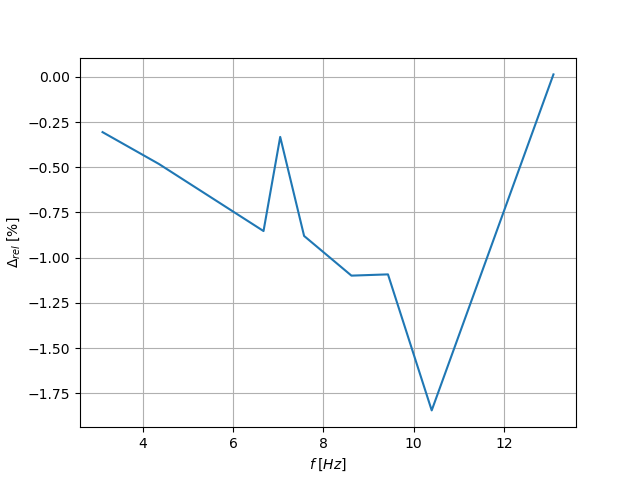

Text(0.5, 0, '$f\\;[Hz]$')

In [995]:
fig, ax = plt.subplots()
#freqs = sorted([ f for f, _1, _2 in run_spans.values() ])
#ax.plot(freqs[:-1], [ delta_abs for delta_abs, _delta_rel in deltas[:-1] ])
#ax.set_ylabel('$\Delta_{abs}\;[Hz]$')

#ax = ax.twinx()
ax.grid()
ax.plot(freqs[:-1], [ delta_rel*100 for _delta_abs, delta_rel in deltas[:-1] ])#, color='orange')
ax.set_ylabel('$\Delta_{rel}\;[\%]$')

ax.set_xlabel('$f\;[Hz]$')

<IPython.core.display.Javascript object>


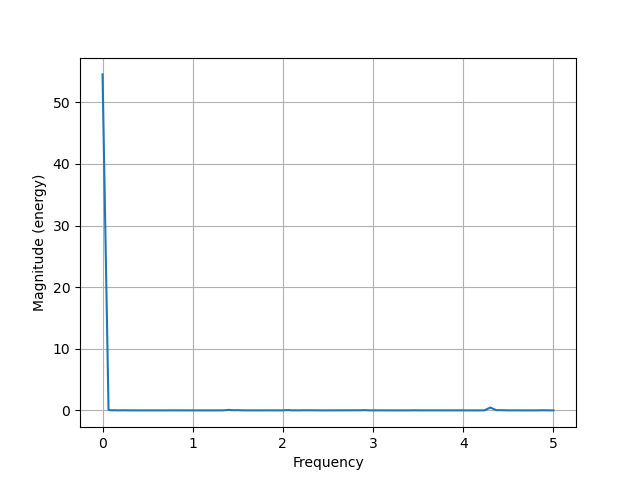

In [718]:
fig, ax = plt.subplots()
ax.grid()
ax.magnitude_spectrum(reassembled_values[ivl_start:ivl_end]/mems_lsb_per_g, Fs=10);

In [719]:
r_mems = 55e-3 # radius of our sensor from the axis of rotation in m
f = largest_peak_f
omega = 2*np.pi*f # angular velocity
centrifugal_acceleration = omega**2 * r_mems # m/s^2

f2 = 1/interval
omega2 = 2*np.pi*f2 # angular velocity
centrifugal_acceleration2 = omega2**2 * r_mems # m/s^2

print(f'Centrifugal acceleration at {largest_peak_f:.2f} Hz: {centrifugal_acceleration:.2f} m/s^2 / {centrifugal_acceleration/g:.2f} g')
print(f'Centrifugal acceleration at {f2:.2f} Hz: {centrifugal_acceleration2:.2f} m/s^2 / {centrifugal_acceleration2/g:.2f} g')

Centrifugal acceleration at 4.31 Hz: 40.42 m/s^2 / 4.12 g
Centrifugal acceleration at 15.73 Hz: 537.19 m/s^2 / 54.78 g


In [720]:
for fn in [0.1, 0.2, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,
           11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0]:

    omegan = 2*np.pi*fn # angular velocity
    acc = omegan**2 * r_mems # m/s^2
    print(f'Centrifugal acceleration at {fn:.2f} Hz: {acc:.2f} m/s^2 / {acc/g:.2f} g')

Centrifugal acceleration at 0.10 Hz: 0.02 m/s^2 / 0.00 g
Centrifugal acceleration at 0.20 Hz: 0.09 m/s^2 / 0.01 g
Centrifugal acceleration at 0.50 Hz: 0.54 m/s^2 / 0.06 g
Centrifugal acceleration at 1.00 Hz: 2.17 m/s^2 / 0.22 g
Centrifugal acceleration at 1.50 Hz: 4.89 m/s^2 / 0.50 g
Centrifugal acceleration at 2.00 Hz: 8.69 m/s^2 / 0.89 g
Centrifugal acceleration at 2.50 Hz: 13.57 m/s^2 / 1.38 g
Centrifugal acceleration at 3.00 Hz: 19.54 m/s^2 / 1.99 g
Centrifugal acceleration at 3.50 Hz: 26.60 m/s^2 / 2.71 g
Centrifugal acceleration at 4.00 Hz: 34.74 m/s^2 / 3.54 g
Centrifugal acceleration at 4.50 Hz: 43.97 m/s^2 / 4.48 g
Centrifugal acceleration at 5.00 Hz: 54.28 m/s^2 / 5.54 g
Centrifugal acceleration at 6.00 Hz: 78.17 m/s^2 / 7.97 g
Centrifugal acceleration at 7.00 Hz: 106.39 m/s^2 / 10.85 g
Centrifugal acceleration at 8.00 Hz: 138.96 m/s^2 / 14.17 g
Centrifugal acceleration at 9.00 Hz: 175.88 m/s^2 / 17.93 g
Centrifugal acceleration at 10.00 Hz: 217.13 m/s^2 / 22.14 g
Centrifugal

<IPython.core.display.Javascript object>


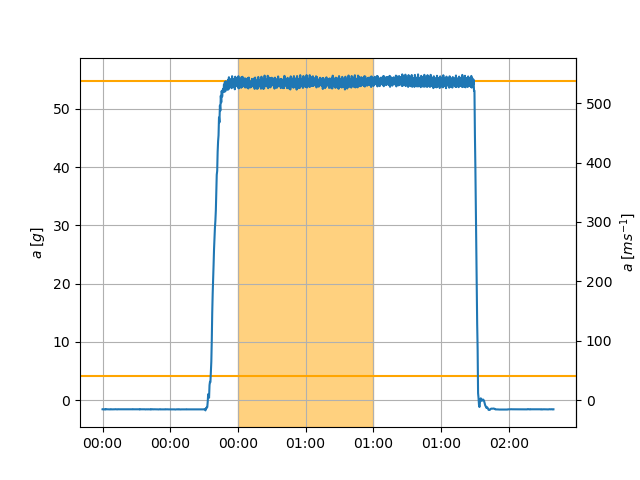

In [721]:
sampling_rate = 10 # sps, set in firmware
mems_lsb_per_g = 68 # LSBs per 1g for our accelerometer

fig, ax = plt.subplots()
ax.axvspan(ivl_start/60/sampling_rate, ivl_end/60/sampling_rate, color='orange', alpha=0.5)
ax.axhline(centrifugal_acceleration/g, color='orange')
ax.axhline(centrifugal_acceleration2/g, color='orange')
interval
ts = np.arange(0, len(reassembled_values)) / sampling_rate / 60
ax.plot(ts, reassembled_values / mems_lsb_per_g )
ax.grid()

g = 9.8066
g_to_ms = lambda x: x * g
ms_to_g = lambda x: x / g

ax.set_ylabel(r'$a\; [g]$')
secax_y = ax.secondary_yaxis(
    'right', functions=(g_to_ms, ms_to_g))
secax_y.set_ylabel(r'$a\; [ms^{-1}]$')

formatter = ticker.FuncFormatter(lambda tick, _pos: f'{tick:02.0f}:{tick*60%1:02.0f}')
ax.xaxis.set_major_formatter(formatter)